<a href="https://colab.research.google.com/github/PigeonLore/Sales-Prediction-Modeling/blob/main/Sales_Predictions_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.linear_model import Ridge
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer

In [71]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
df = pd.read_csv('/content/drive/MyDrive/Coding Dojo | Data Science/Stack 2: Machine Learning/Week 1: Machine Learning/DataSets/sales_predictions.csv')

# 1. Inspecting Data

In [73]:
# Display Column names, counts of non-null values, and respective datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [74]:
# Display statistics for numerical columns
df.describe(include='number')

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,"7,060.00","8,523.00","8,523.00","8,523.00","8,523.00"
mean,12.86,0.07,140.99,"1,997.83","2,181.29"
std,4.64,0.05,62.28,8.37,"1,706.50"
min,4.55,0.00,31.29,"1,985.00",33.29
25%,8.77,0.03,93.83,"1,987.00",834.25
50%,12.60,0.05,143.01,"1,999.00","1,794.33"
75%,16.85,0.09,185.64,"2,004.00","3,101.30"
max,21.35,0.33,266.89,"2,009.00","13,086.96"


In [75]:
# Display 
df.describe(include='object')

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,8523,8523,8523,8523,6113,8523,8523
unique,1559,5,16,10,3,3,4
top,FDW13,Low Fat,Fruits and Vegetables,OUT027,Medium,Tier 3,Supermarket Type1
freq,10,5089,1232,935,2793,3350,5577


# 2. Correct Discrepancies

In [76]:
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

## 1. This standardizes all elements representing low fat and regular to discrete items

In [77]:
# Correct 

df['Item_Fat_Content'].replace({'low fat':0,'LF':0,'Low Fat':0,'reg':1,'Regular':1},inplace=True)

In [78]:
df['Item_Fat_Content'].value_counts()

0    5517
1    3006
Name: Item_Fat_Content, dtype: int64

## 2. Check for duplicates

In [79]:
# Display duplicated data

print('There are',df.duplicated().sum(),'duplicates')

There are 0 duplicates


## 3. Check for missing values

In [80]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [81]:
#Displays the percentage of missing values of each column

print(df.isna().sum()/len(df)*100,'%')

Item_Identifier              0.00
Item_Weight                 17.17
Item_Fat_Content             0.00
Item_Visibility              0.00
Item_Type                    0.00
Item_MRP                     0.00
Outlet_Identifier            0.00
Outlet_Establishment_Year    0.00
Outlet_Size                 28.28
Outlet_Location_Type         0.00
Outlet_Type                  0.00
Item_Outlet_Sales            0.00
dtype: float64 %


# 3. Define target and feature sets then perform a train test split.

## 1. Spliting data

In [82]:
X = df.drop(columns=(['Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Identifier', 'Outlet_Establishment_Year']))

y = df['Item_Outlet_Sales']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [84]:
X_train.isna().any()

Item_Weight              True
Item_Fat_Content        False
Item_Visibility         False
Item_Type               False
Item_MRP                False
Outlet_Size              True
Outlet_Location_Type    False
Outlet_Type             False
dtype: bool

## 2. PreProcessing

In [85]:
# X_train['Outlet_Size'].replace({'High':0, 'Medium':1,'Small':2}, inplace = True)
X_train['Outlet_Size'].unique()

array(['Medium', 'Small', nan, 'High'], dtype=object)

### Column Selectors

In [86]:
#Instantiate column selectors

num_selector = make_column_selector(dtype_include='number')

cat_selector = make_column_selector(dtype_include='object')

In [87]:
# Instantiate Columns selectors

num_columns = num_selector(X_train)
cat_columns = cat_selector(X_train)

In [88]:
# Instantiate imputers

freq_imputer = SimpleImputer(strategy='most_frequent')

mean_imputer = SimpleImputer(strategy='mean')

# Instantiate Scalers

scaler = StandardScaler()

# Instantiate OneHotEncoding

ohe = OneHotEncoder(sparse_output = False, handle_unknown='ignore')

## Create Pipelines

In [89]:
num_pipe, cat_pipe = make_pipeline(mean_imputer, scaler), make_pipeline(freq_imputer, ohe)

print(num_pipe)
print(cat_pipe)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])
Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])


### Tuples

In [90]:
# Create Tupes

num_tuple = (num_pipe, num_selector)

cat_tuple = (cat_pipe, cat_selector)

### PreProcessor

In [91]:
preprocessor = make_column_transformer(num_tuple, cat_tuple, remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f3bc02f2310>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f3bc02f2a00>)])

In [92]:
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f3bc02f2310>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f3bc02f2a00>)])

# 3. Pipelines

In [93]:
X_train_processed = preprocessor.transform(X_train)

X_test_processed = preprocessor.transform(X_test)

X_train_processed[:10]

array([[ 8.17248678e-01, -7.40320602e-01, -7.12775072e-01,
         1.82810922e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 5.56339503e-01,  1.35076614e+00, -1.29105225e+00,
         6.03368881e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+

In [94]:
X_train_df = pd.DataFrame(X_train_processed)

X_train_df

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.82,-0.74,-0.71,1.83,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
1,0.56,1.35,-1.29,0.60,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
2,-0.13,1.35,1.81,0.24,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
3,-1.17,-0.74,-1.00,-0.95,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
4,1.53,-0.74,-0.97,-0.34,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,-0.83,1.35,4.31,-0.04,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00
6388,0.64,-0.74,1.01,-1.06,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
6389,1.11,-0.74,-0.92,1.52,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
6390,1.77,-0.74,-0.23,-0.38,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00


In [95]:
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
X_train_processed.shape

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (6392, 30)




(6392, 30)

# Modeling Sales Predictions with Linear Regression Models

In [96]:
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

## Create functions for metrics

In [97]:
def regression_metrics(model, X_train, X_test, y_train, y_test):

    # Fit the model
    # model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = model.predict(X_test)

    # Calculate the regression metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)

    # Create a data frame to store the results

    pd.options.display.float_format = '{:,.2f}'.format

    results = pd.DataFrame({'Metrics': ['MAE', 'MSE', 'R2', 'RMSE'],
                            'Values': [mae, mse, r2, rmse]})

    # Print the results
    results    

    # Return the metrics as a dictionary
    return results


In [98]:
def model_score(model, X_train, X_test, y_train, y_test):
    # Fit the model
    # model.fit(X_train, y_train)

    # Calculate the training and testing scores
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    # Create a data frame to store the results
    results = pd.DataFrame({'Score Type': ['Training', 'Testing'],
                            'Score': [train_score, test_score]})

    # Print the results
    # print(model)
    # print(results.head())

    # Return the scores as a dictionary
    return results

# Fitting and evaluating models using regression metrics

## Random Forest Regressor

In [99]:
# Instance Random Forest Regressor

rfr = RandomForestRegressor()

In [100]:
# Fit data to Random Forest Regressor

rfr.fit(X_train_df, y_train)

RandomForestRegressor()

In [101]:
# Run regression metrics for model

regression_metrics(rfr, X_train_processed, X_test_processed, y_train, y_test)

,Metrics,Values
0,MAE,778.91
1,MSE,"1,257,679.45"
2,R2,0.54
3,RMSE,"1,121.46"


In [102]:
model_score(rfr, X_train_processed, X_test_processed, y_train, y_test)

,Score Type,Score
0,Training,0.94
1,Testing,0.54


## Linear Regressor

In [103]:
#Instance Linear Regressor

linReg = LinearRegression()

In [104]:
# Fit data to Linear Regressor

linReg_pipe = make_pipeline(scaler, linReg)

linReg_pipe.fit(X_train_processed, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [105]:
# Run regression metrics for trained model

regression_metrics(linReg_pipe, X_train_processed, X_test_processed, y_train, y_test)

,Metrics,Values
0,MAE,807.18
1,MSE,"1,199,478.97"
2,R2,0.57
3,RMSE,"1,095.21"


In [106]:
linReg_pipe.predict(X_test_processed)

array([1381.75166987,  802.75166987,  831.00166987, ..., 3415.75166987,
       1978.25166987, 2440.25166987])

In [107]:
model_score(linReg_pipe, X_train_processed, X_test_processed, y_train, y_test)

,Score Type,Score
0,Training,0.56
1,Testing,0.57


## Decision Tree Regressor

In [108]:
# Instance Decision Tree Regressor

DecTreeReg = DecisionTreeRegressor()

In [109]:
# Fit data to Decision Tree Regressor

DecTreeReg.fit(X_train_processed, y_train)

DecisionTreeRegressor()

In [110]:
# Run regression metric for trained model

regression_metrics(DecTreeReg, X_train_processed, X_test_processed, y_train, y_test)

,Metrics,Values
0,MAE,"1,070.87"
1,MSE,"2,402,932.78"
2,R2,0.13
3,RMSE,"1,550.14"


# Tuning Models

## Exploring hyperparameters

## Random Forest Regression

In [111]:
rfr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [112]:
rfr_est_depths = [estimator.get_depth() for estimator in rfr.estimators_]
max(rfr_est_depths)

49

In [113]:
model_score(rfr, X_train_processed, X_test_processed, y_train, y_test)

,Score Type,Score
0,Training,0.94
1,Testing,0.54


In [114]:
print(max(rfr_est_depths))
print(min(rfr_est_depths))

49
30


### Random Forest Regression Hyperparameter tuning using loops

In [142]:
%%time

rfr_depths = range(1,max(rfr_est_depths))
rfr_leafs = np.arange(0.1, 1, 0.1)
rfr_scores = pd.DataFrame(index=rfr_depths, columns=['Test Score'])

for depth in rfr_depths:
  for leaf in rfr_leafs:
    rfr_model = RandomForestRegressor(max_depth=depth,  min_samples_leaf= leaf)

    rfr_model_pipe = make_pipeline(scaler, rfr_model) 

    rfr_model_pipe.fit(X_train_processed, y_train)
  
    rfr_scores.loc[depth, 'Train Score'] = rfr_model_pipe.score(X_train_processed, y_train)
    rfr_scores.loc[depth, 'Test Score'] = rfr_model_pipe.score(X_test_processed, y_test)

CPU times: user 2min 11s, sys: 551 ms, total: 2min 11s
Wall time: 2min 15s


,Test Score,Train Score
25,-0.00,-0.00
14,-0.00,-0.00
41,-0.00,-0.00
19,-0.00,-0.00
38,-0.00,-0.00
47,-0.00,-0.00
4,-0.00,-0.00
5,-0.00,-0.00
30,-0.00,-0.00
20,-0.00,-0.00


In [143]:
rfr_scores

,Test Score,Train Score
1,-0.00,-0.00
2,-0.01,-0.00
3,-0.00,-0.00
4,-0.00,-0.00
5,-0.00,-0.00
6,-0.00,-0.00
7,-0.00,-0.00
8,-0.00,-0.00
9,-0.00,-0.00
10,-0.00,-0.00


In [115]:
rfr_scores_sorted = rfr_scores.sort_values(by= 'Test Score', ascending = False)

In [116]:
rfr_scores_sorted.head()

,Test Score,Train Score
32,0.32,0.32
28,0.32,0.32
37,0.32,0.32
41,0.32,0.32
13,0.32,0.32


In [117]:
rfr_best = rfr_scores_sorted.index[0]

rfr_tune = RandomForestRegressor(max_depth = rfr_best, random_state = 42)

In [118]:
rfr_tune.fit(X_train_processed, y_train)

RandomForestRegressor(max_depth=32, random_state=42)

In [119]:
model_score(rfr_tune, X_train_processed, X_test_processed, y_train, y_test)

,Score Type,Score
0,Training,0.94
1,Testing,0.54


### We can retune the model for better results

In [120]:
%%time

rfr_n_list = []
for i in range(1,100):
  rfr_n_list.append(i)

estimators = rfr_n_list

rfr_tune_scores = pd.DataFrame(index=estimators, columns=['Train Score', 'Test Score'])



for num_estimators in estimators:

  rfr_tuned = RandomForestRegressor(n_estimators=num_estimators, random_state=42)

  rfr_tuned_pipe = make_pipeline(scaler, rfr_tuned) 

  rfr_tuned_pipe.fit(X_train_processed, y_train)

  train_score = rfr_tuned_pipe.score(X_train_processed, y_train)
  test_score = rfr_tuned_pipe.score(X_test_processed, y_test)

  rfr_tune_scores.loc[num_estimators, 'Train Score'] = train_score
  rfr_tune_scores.loc[num_estimators, 'Test Score'] = test_score

CPU times: user 3min 42s, sys: 455 ms, total: 3min 42s
Wall time: 4min 7s


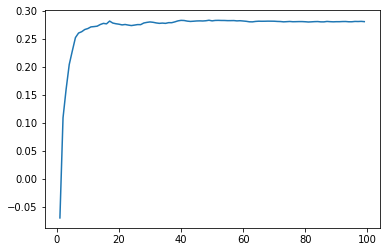

In [121]:
plt.plot(rfr_tune_scores['Test Score'])
plt.show()

In [122]:
rfr_tune_scores.sort_values(by = 'Test Score', ascending = False)

,Train Score,Test Score
49,0.50,0.28
40,0.50,0.28
52,0.50,0.28
51,0.50,0.28
53,0.50,0.28
...,...,...
5,0.44,0.23
4,0.43,0.20
3,0.40,0.16
2,0.36,0.11


## Decision Tree Regression

In [123]:
DecTreeReg.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [124]:
DecTreeReg.get_depth()

42

In [125]:
DecTreeReg.get_n_leaves()

6257

In [126]:
model_score(DecTreeReg, X_train_processed, X_test_processed, y_train, y_test)

,Score Type,Score
0,Training,1.00
1,Testing,0.13


### Decision Tree Regression Tuning using loops

In [127]:
%%time

depths = range(1,38)

scores = pd.DataFrame(index=depths, columns=['Test Score','Train Score'])

for depth in depths:

    dec_tree = DecisionTreeRegressor(max_depth=depth, random_state=42)

    dec_tree_pipe = make_pipeline(scaler, dec_tree)

    dec_tree_pipe.fit(X_train_processed, y_train)
    
    train_score = dec_tree_pipe.score(X_train_processed, y_train)
    test_score = dec_tree_pipe.score(X_test_processed, y_test)
    
    scores.loc[depth, 'Train Score'] = train_score
    scores.loc[depth, 'Test Score'] = test_score

scores.sort_values(by = 'Test Score', ascending = False)

CPU times: user 1.86 s, sys: 12 ms, total: 1.87 s
Wall time: 1.89 s


,Test Score,Train Score
6,0.31,0.32
5,0.31,0.32
4,0.30,0.30
7,0.29,0.31
8,0.28,0.32
9,0.27,0.32
10,0.25,0.32
3,0.25,0.26
11,0.23,0.33
1,0.23,0.24


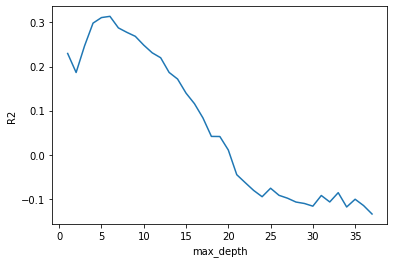

In [128]:
plt.plot(depths, scores['Test Score'])
plt.xlabel('max_depth')
plt.ylabel('R2');

In [129]:
best_score = scores.index[4]

Dec_tuneBest = DecisionTreeRegressor(max_depth = best_score, random_state= 42)

Dec_tuneBest.fit(X_train_processed, y_train)

Dec_tuneBest

DecisionTreeRegressor(max_depth=5, random_state=42)

# Display all model scores

In [130]:
regression_metrics(rfr_tune, X_train_processed, X_test_processed, y_train, y_test)

,Metrics,Values
0,MAE,776.21
1,MSE,"1,258,340.54"
2,R2,0.54
3,RMSE,"1,121.76"


In [131]:
regression_metrics(Dec_tuneBest, X_train_processed, X_test_processed, y_train, y_test)

,Metrics,Values
0,MAE,738.32
1,MSE,"1,118,185.97"
2,R2,0.59
3,RMSE,"1,057.44"


In [132]:
regression_metrics(linReg_pipe, X_train_processed, X_test_processed, y_train, y_test)

,Metrics,Values
0,MAE,807.18
1,MSE,"1,199,478.97"
2,R2,0.57
3,RMSE,"1,095.21"


# From the metrics displayed, the Decision Tree Regression displays the best R^2 score for the data provided. 